In [23]:
import tensorflow as tf
from PIL import Image
import numpy as np
import pandas as pd
from mtcnn.mtcnn import MTCNN
import cv2
import os
import sys
from matplotlib import pyplot
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import smtplib
from string import Template
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from scipy.spatial.distance import cosine

In [5]:
# Reference
# https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/
# Extract the face from the image
def face_extraction(image_address, m, n):
    image = Image.open(image_address).convert('RGB')
    image_array = np.asarray(image)
    # To get the coordinates of the face in the image using MTCNN
    face_cor = MTCNN().detect_faces(image_array)
    # w and h are the width and height
    x_cor, y_cor, w, h = face_cor[0]['box']
    image_array = image_array[y_cor:(y_cor+h), x_cor:(x_cor+w)]
    image = Image.fromarray(image_array)
    image = image.resize((m,n))
    return np.asarray(image)
# Function Call parameters - image, dimensions(x,y)
# face_extraction("elon_musk_1.jpg", 160, 160)

In [6]:
# all face data stored in numpy array
def prepare_dataset(location):
    x_train = list()
    y_train = list()
    for sub_folder in os.listdir(location):
        subfolder_face = list()
        str_location = location + "/" + sub_folder
        if(sub_folder == ".DS_Store"):
            continue
        for files in os.listdir(str_location):
            if(files == ".DS_Store"):
                continue
            file_location = str_location + "/" + files
            #print(file_location)
            # 160,160 is the input dimension of the FaceNet trained model used
            subfolder_face.append(face_extraction(file_location, 160, 160))
        # print(sub_folder, len(subfolder_face))
        x_train.extend(subfolder_face)
        y_train.extend(sub_folder for _ in range(len(subfolder_face)))
    return np.asarray(x_train), np.asarray(y_train)
# function call parameter - image location
# x_train_data, y_train_data = prepare_dataset("dataset/train")

In [7]:
# extract the face feature using FaceNet model
def feature_extraction(x_train_data, y_train_data, model):
    feature_extracted = list()
    for pics in x_train_data:
        pics = pics.astype('float32')
        pics = (pics - pics.mean())/pics.std()
        pics = np.expand_dims(pics, axis=0)
        y_prediction = model.predict(pics)
        feature_extracted.append(y_prediction[0])
    feature_extracted = np.asarray(feature_extracted)
    return feature_extracted
# function call parameter - x_train_data(numpy array), CNN model
# feature_extraction(x_train_data, model)

In [8]:
# Training
# Prepare dataset
#print("training data")
x_train_data, y_train_data = prepare_dataset("dataset_one_shot/train") # Train
#print("test data")
x_test_data, y_test_data = prepare_dataset("dataset_one_shot/test") # Test
print("train data")
print(x_train_data.shape)
print("test data")
print(x_test_data.shape)
# Save train and test features
np.savez_compressed('dataset.npz', x_train_data, y_train_data, x_test_data, y_test_data)
# Load Pre-Trained Model
CNN_model = load_model('keras-facenet/model/facenet_keras.h5')
# feature extraction
# Train
x_train_feature = feature_extraction(x_train_data, y_train_data, CNN_model)
df_1 = pd.DataFrame(x_train_feature)
df_2 = pd.DataFrame(y_train_data)
train_database = pd.concat([df_1, df_2], axis=1, ignore_index = True)
# Test
x_test_feature = feature_extraction(x_test_data, y_test_data, CNN_model)
df_1 = pd.DataFrame(x_test_feature)
df_2 = pd.DataFrame(y_test_data)
test_database = pd.concat([df_1, df_2], axis=1, ignore_index = True)






Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

train data
(35, 160, 160, 3)
test data
(294, 160, 160, 3)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
# calculate Accuracy for one shot learning
test_np_db = np.array(test_database)
train_np_db = np.array(train_database)
test_y = np.array([])
for i in range(0, test_database.shape[0]):
    test_y = np.append(test_y, ["Unknown"])
    final_difference = 9999
    for j in range(0, train_database.shape[0]):
        image_difference = np.linalg.norm(test_np_db[i, 0:(test_np_db.shape[1] - 1)] - train_np_db[j, 0:(train_np_db.shape[1] - 1)])
        if(image_difference < final_difference):
            final_difference = image_difference
            test_y[i] = train_np_db[j,128]

test_acc = accuracy_score(test_y, test_np_db[:,128])
test_confusion_matrix = confusion_matrix(test_y, test_np_db[:,128])
print("Test Confusion matrix:")
print(test_confusion_matrix)
FP = (test_confusion_matrix.sum(axis=0) - np.diag(test_confusion_matrix)).astype(float)
FN = (test_confusion_matrix.sum(axis=1) - np.diag(test_confusion_matrix)).astype(float)
TP = (np.diag(test_confusion_matrix)).astype(float)
TN = (test_confusion_matrix.sum() - (FP + FN + TP)).astype(float)

# Accuracy
print("Accuracy")
print(test_acc)

# Sensitivity
true_positive_rate = TP/(TP+FN)
print("Sensitivity/True Positive Rate")
print(np.sum(true_positive_rate)/len(true_positive_rate))

# Specificity or true negative rate
true_negative_rate = TN/(TN+FP)
print("Specificity/True Negative Rate")
print(np.sum(true_negative_rate)/len(true_negative_rate))

Test Confusion matrix:
[[18  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0]
 [ 0 21  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 19  0  0  0  0  0  0  0  0  1  1  0]
 [ 0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  8  1  0  0  1  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0 12  0  0  0  0  1  0  0]
 [ 1  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 24  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  1]
 [ 0  0  0  0  0  0  0  1  0  0  1  0  0  0  0 18  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 16]]
Accuracy
0.935374149659864
Sensitivity/True Positive Rate


In [10]:
def face_prediction(image_address, m, n, CNN_model, train_database):
    image = Image.open(image_address).convert('RGB')
    image_input = np.asarray(image)
    image_array = image_input
    # To get the coordinates of the face in the image
    face_cor = MTCNN().detect_faces(image_array)
    # w and h are the width and height
    x_cor, y_cor, w, h = face_cor[0]['box']
    # face extraction
    image_array = image_array[y_cor:(y_cor+h), x_cor:(x_cor+w)]
    image = Image.fromarray(image_array)
    pyplot.subplot(1, 1, 1)
    pyplot.axis('off')
    pyplot.imshow(image_input)
    image = image.resize((m,n))
    image_array = np.asarray(image)
    image_array = image_array.astype('float32')
    image_array = (image_array - image_array.mean())/image_array.std()
    image_array = np.expand_dims(image_array, axis=0)
    # feature extraction
    image_prediction = CNN_model.predict(image_array)
    train_np = np.array(train_database)
    result_np = np.array(image_prediction)
    final_difference = 100
    for i in range(0, train_database.shape[0]):
        difference = np.linalg.norm(result_np - train_np[i, 0:(train_np.shape[1] - 1)])
        if(difference < final_difference):
            final_difference = difference
            person_name = train_np[i, 128]

    # below comment will draw a bounding box around the text and will add text
    img = cv2.rectangle(image_input,(x_cor,y_cor),(x_cor+w,y_cor+h),(0,255,0),4)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,person_name,(x_cor+10,y_cor-10), font, .5,(255,0,0),2,cv2.LINE_AA)
    cv2.imwrite("output_" + image_address,cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    return person_name

person in the image is: dakshin_jawahar


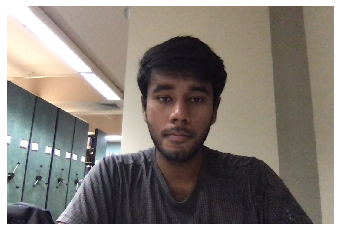

In [11]:
# Image Predictiom
person_name = face_prediction("test_6.jpg", 160, 160, CNN_model, train_database)
print("person in the image is: " + person_name)

In [12]:
def face_prediction_video(image_address, m, n, CNN_model, train_database):
    #image = Image.open(image_address).convert('RGB')
    image_input = np.asarray(image_address)
    image_array = image_input
    # To get the coordinates of the face in the image
    face_cor = MTCNN().detect_faces(image_array)
    if (len(face_cor) != 0 and all(i > 0 for i in face_cor[0]['box'])):
        # w and h are the width and height
        x_cor, y_cor, w, h = face_cor[0]['box']
        # face extraction
        # print(face_cor[0]['box'])
        image_array = image_array[y_cor:(y_cor+h), x_cor:(x_cor+w)]
        image = Image.fromarray(image_array)
        image = image.resize((m,n))
        image_array = np.asarray(image)
        image_array = image_array.astype('float32')
        image_array = (image_array - image_array.mean())/image_array.std()
        image_array = np.expand_dims(image_array, axis=0)
        # feature extraction
        image_prediction = CNN_model.predict(image_array)
        train_np = np.array(train_database)
        result_np = np.array(image_prediction)
        final_difference = 100
        for i in range(0, train_database.shape[0]):
            difference = np.linalg.norm(result_np - train_np[i, 0:(train_np.shape[1] - 1)])
            if(difference < final_difference):
                final_difference = difference
                person_name = train_np[i, 128]

        # below comment will draw a bounding box around the text and will add text
        img = cv2.rectangle(image_input,(x_cor,y_cor),(x_cor+w,y_cor+h),(0,255,0),4)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img,person_name,(x_cor+10,y_cor-10), font, .5,(255,0,0),2,cv2.LINE_AA)
        # cv2.imwrite("output_" + image_address,cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        return img
    else:
        return image_input

In [13]:
def video_processing(video_address, output_address):
    cam = cv2.VideoCapture(video_address)
    video = cv2.VideoWriter(output_address, cv2.VideoWriter_fourcc(*'DIVX'), 30, (1080,720))
    currentframe = 0
    while(True):
        ret,frame = cam.read()
        if ret:
            frame = face_prediction_video(frame, 160, 160, CNN_model, train_database)
            # Appending the images to the video one by one
            # name = 'video_dataset/' + str(currentframe) + '.jpg'
            # cv2.imwrite(name, frame)
            video.write(frame)
            currentframe += 1
            #print(currentframe, end = " => ")
        else:
            break
    cam.release() 
    video.release()
    cv2.destroyAllWindows()
    return "Success"

In [14]:
# Video Prediction
result = video_processing("video_dataset/meAndRommates.mov", "video_dataset/meAndRommates_oneShot_output.avi")
print(result)

Success


# Recognize face - Webcam

In [12]:
# For Webcam
def face_prediction_webcam(image_address, m, n, CNN_model, train_database):
    #image = Image.open(image_address).convert('RGB')
    image_input = np.asarray(image_address)
    image_array = image_input
    # To get the coordinates of the face in the image
    face_cor = MTCNN().detect_faces(image_array)
    if (len(face_cor) != 0 and all(i > 0 for i in face_cor[0]['box'])):
        # w and h are the width and height
        x_cor, y_cor, w, h = face_cor[0]['box']
        # face extraction
        # print(face_cor[0]['box'])
        image_array = image_array[y_cor:(y_cor+h), x_cor:(x_cor+w)]
        image = Image.fromarray(image_array)
        image = image.resize((m,n))
        image_array = np.asarray(image)
        image_array = image_array.astype('float32')
        image_array = (image_array - image_array.mean())/image_array.std()
        image_array = np.expand_dims(image_array, axis=0)
        # feature extraction
        image_prediction = CNN_model.predict(image_array)
        train_np = np.array(train_database)
        result_np = np.array(image_prediction)
        final_difference = 100
        for i in range(0, train_database.shape[0]):
            difference = np.linalg.norm(result_np - train_np[i, 0:(train_np.shape[1] - 1)])
            if(difference < final_difference):
                final_difference = difference
                person_name = train_np[i, 128]

        # below comment will draw a bounding box around the text and will add text
        img = cv2.rectangle(image_input,(x_cor,y_cor),(x_cor+w,y_cor+h),(0,255,0),4)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img,person_name,(x_cor+10,y_cor-10), font, .5,(255,0,0),2,cv2.LINE_AA)
        # cv2.imwrite("output_" + image_address,cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        return img
    else:
        return image_input

In [13]:
cascPath = sys.argv[1]
faceCascade = cv2.CascadeClassifier(cascPath)

video_capture = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    frame = face_prediction_webcam(frame, 160, 160, CNN_model, train_database)
    # Display the resulting frame
    cv2.imshow('Video', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

# Notification

In [34]:
def read_text(filename):
    with open(filename, 'r', encoding='utf-8') as template_file:
        template_file_content = template_file.read()
    return Template(template_file_content)

In [35]:
def send_alert(sender_address, sender_password, recipient_name, recipient_mail):
    s = smtplib.SMTP(host='smtp.gmail.com', port = 587)
    s.ehlo()
    s.starttls()
    s.login(sender_address, sender_password)
    
    msg = MIMEMultipart()       # create a message
    message_template = read_text("message.txt")
    message = message_template.substitute(PERSON_NAME=recipient_name)
    
    msg['From']= sender_address
    msg['To']= recipient_mail
    msg['Subject'] = "Alert: Home applicance active!!"
    
    msg.attach(MIMEText(message, 'plain'))
    
    s.send_message(msg)
    del msg
    return "success"

In [36]:
def face_prediction_video_notification(image_address, m, n, CNN_model, train_database):
    #image = Image.open(image_address).convert('RGB')
    image_input = np.asarray(image_address)
    image_array = image_input
    # To get the coordinates of the face in the image
    face_cor = MTCNN().detect_faces(image_array)
    if (len(face_cor) != 0 and all(i > 0 for i in face_cor[0]['box'])):
        # w and h are the width and height
        x_cor, y_cor, w, h = face_cor[0]['box']
        # face extraction
        image_array = image_array[y_cor:(y_cor+h), x_cor:(x_cor+w)]
        image = Image.fromarray(image_array)
        image = image.resize((m,n))
        image_array = np.asarray(image)
        image_array = image_array.astype('float32')
        image_array = (image_array - image_array.mean())/image_array.std()
        image_array = np.expand_dims(image_array, axis=0)
        # feature extraction
        image_prediction = CNN_model.predict(image_array)
        train_np = np.array(train_database)
        result_np = np.array(image_prediction)
        final_difference = 100
        for i in range(0, train_database.shape[0]):
            difference = np.linalg.norm(result_np - train_np[i, 0:(train_np.shape[1] - 1)])
            if(difference < final_difference):
                final_difference = difference
                person_name = train_np[i, 128]

        # below comment will draw a bounding box around the text and will add text
        img = cv2.rectangle(image_input,(x_cor,y_cor),(x_cor+w,y_cor+h),(0,255,0),4)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img,person_name,(x_cor+10,y_cor-10), font, .5,(255,0,0),2,cv2.LINE_AA)
        # cv2.imwrite("output_" + image_address, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        return img, y_cor, person_name
    else:
        return image_input, 0, ""

In [37]:
def video_processing_notification(people_in_home, video_address, output_address, appliance_status):
    cam = cv2.VideoCapture(video_address)
    video = cv2.VideoWriter(output_address, cv2.VideoWriter_fourcc(*'DIVX'), 30, (1080,720))
    currentframe = 0
    count_zero = 0;
    y_list = []
    while(True):
        ret,frame = cam.read()
        if ret:
            
            frame, y_cor, person_name = face_prediction_video_notification(frame, 160, 160, CNN_model, train_database)
            
            # Tracking the person - if he is approaching the exit
            if person_name != "":
                recipient_name = person_name

            if y_cor == 0:
                count_zero = count_zero + 1
            else:
                y_list.append(y_cor)
            
            if count_zero == 60:
                if len(y_list) > 10:
                    # Check whether the person is approaching the door(exit)
                    tracking_var = (y_list[len(y_list)-1] - y_list[len(y_list)-2])
                    tracking_var = tracking_var + (y_list[len(y_list)-7] - y_list[len(y_list)-6])
                    tracking_var = tracking_var + (y_list[len(y_list)-6] - y_list[len(y_list)-5])
                    tracking_var = tracking_var + (y_list[len(y_list)-5] - y_list[len(y_list)-4])
                    tracking_var = tracking_var + (y_list[len(y_list)-4] - y_list[len(y_list)-3])
                    tracking_var = tracking_var + (y_list[len(y_list)-3] - y_list[len(y_list)-2])
                    tracking_var = tracking_var + (y_list[len(y_list)-2] - y_list[len(y_list)-1])
                count_zero = 0
                y_list = []
                if len(people_in_home) == 1 and tracking_var < 0:
                    if people_in_home.get(recipient_name) != None and appliance_status == 1:
                        # 1st parameter - send email
                        # 2nd parameter - password
                        # make sure to turn on the less secure app feature in the account you are going to use
                        send_alert("xyz@gmail.com", "Password", recipient_name, 
                                   people_in_home.get(recipient_name))
                        people_in_home.pop(recipient_name)
                else:
                    people_in_home.pop(recipient_name)
            
            # Appending the images to the video one by one
            name = 'video_dataset/' + str(currentframe) + '.jpg'
            cv2.imwrite(name, frame)
            video.write(frame)
            currentframe += 1
            print(currentframe, end = " => ")
        else:
            break
    cam.release() 
    video.release()
    cv2.destroyAllWindows()
    return 1

In [38]:
people_in_home = {
  "dakshin_jawahar": "dax_dakshin@yahoo.in"
#  "shriram_ramdoss": "dax_dakshin@yahoo.in"
#  "prasad": "dax_dakshin@yahoo.in"
}
result = video_processing_notification(people_in_home, "video_dataset/notification_simulation.mov", "video_dataset/notification_simulation_oneShot.avi", appliance_status = 1)


1 => 2 => 3 => 4 => 5 => 6 => 7 => 8 => 9 => 10 => 11 => 12 => 13 => 14 => 15 => 16 => 17 => 18 => 19 => 20 => 21 => 22 => 23 => 24 => 25 => 26 => 27 => 28 => 29 => 30 => 31 => 32 => 33 => 34 => 35 => 36 => 37 => 38 => 39 => 40 => 41 => 42 => 43 => 44 => 45 => 46 => 47 => 48 => 49 => 50 => 51 => 52 => 53 => 54 => 55 => 56 => 57 => 58 => 59 => 60 => 61 => 62 => 63 => 64 => 65 => 66 => 67 => 68 => 69 => 70 => 71 => 72 => 73 => 74 => 75 => 76 => 77 => 78 => 79 => 80 => 81 => 82 => 83 => 84 => 85 => 86 => 87 => 88 => 89 => 90 => 91 => 92 => 93 => 94 => 95 => 96 => 97 => 98 => 99 => 100 => 101 => 102 => 103 => 104 => 105 => 106 => 107 => 108 => 109 => 110 => 111 => 112 => 113 => 114 => 115 => 116 => 117 => 118 => 119 => 120 => 121 => 122 => 123 => 124 => 125 => 126 => 127 => 128 => 129 => 130 => 131 => 132 => 133 => 134 => 135 => 